**Using k-Nearest Neighbors to Identify User Ratings**

This particular model uses a concept called neighborhood collaborative filtering to identify a small number of recommended restaurants for a particular user based on the same user's previously-stated preferences for similar restaurants. As was previously mentioned, the sample we are using for this model includes only those reviewers who have reviewed at least 150 restaurants previously, and thus the stated preferences are already present in the sample used for this model. 

The model included here is based on a solution to the same problem for CS109a in 2013. The documentation for this problem can be found here: http://nbviewer.jupyter.org/github/cs109/content/blob/master/HW4_solutions.ipynb


In [13]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
%matplotlib inline

**Read in Data**

The training and test samples used here were created previously prior to beginning analysis. They are the same training and test sets as have been used in previous models throughout this project. 

In [14]:
train_data = pd.read_csv('Data/train/OH/train_150.csv')
test_data = pd.read_csv('Data/test/OH/test_150.csv')

In [15]:
train_data.shape, test_data.shape

((3925, 13), (942, 13))

In [16]:
train_data.head()

,review_date,business_longitude,business_id,business_categories,business_name,business_state,review_score,user_id,user_average_rating,business_review_count,business_average_rating,business_latitude,user_review_count
0,2012-08-09,-81.688974,HNs2Nf-trqFTDtho4vhfmA,"['Bars', 'Lounges', 'Restaurants', 'American (...",The South Side,OH,3.0,3Uv0dGI2IXJb2OUj8R2GJA,3.85,275,3.5,41.482026,482
1,2011-09-27,-81.579720,SP7H3zPArNvbHKQW0c_gpA,"['Restaurants', 'Thai', 'Asian Fusion']",High Thai'd,OH,2.0,3Uv0dGI2IXJb2OUj8R2GJA,3.85,100,4.0,41.510991,482
2,2011-06-20,-81.729861,YgHp9MdZ1vVdYyMEro4TtQ,"['Bars', 'Barbeque', 'Pizza', 'American (New)'...",XYZ the Tavern,OH,4.0,3Uv0dGI2IXJb2OUj8R2GJA,3.85,181,4.0,41.484139,482
3,2014-04-16,-81.730410,wmstf9dw0-kN3YThIxx8eQ,"['Irish', 'Bars', 'Pubs', 'Nightlife', 'Restau...",Stone Mad Pub,OH,4.0,3Uv0dGI2IXJb2OUj8R2GJA,3.85,126,3.5,41.486707,482
4,2010-08-02,-81.690048,Xny0n0s98TpP82sQxfgIMQ,"['Polish', 'Nightlife', 'Restaurants', 'Americ...",Sokolowski's University Inn,OH,3.0,3Uv0dGI2IXJb2OUj8R2GJA,3.85,368,4.5,41.484752,482


**Data Cleaning**

Because this model is based on a user's previous experiences with similar restaurants, we need a way to define which restaurants in this dataset are similar to one another. One such measure is a "common user support", which shows the number of users who have rated any particular pair of restaurants. We need such a measurement because common user support can be used later throughout this problem as a proxy for how similar a pair of restaurants may be to each other.  

Mean support is: 0.259574439166


(array([  1.42330300e+06,   3.55450000e+04,   8.73300000e+03,
          2.49000000e+03,   8.62000000e+02,   3.44000000e+02,
          1.31000000e+02,   4.20000000e+01,   1.70000000e+01,
          3.00000000e+00]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

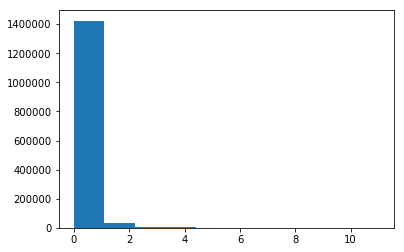

In [17]:
restaurants=train_data.business_id.unique()
supports=[]
for i,rest1 in enumerate(restaurants):
    for j,rest2 in enumerate(restaurants):
        if  i < j:
            rest1_reviewers = train_data[train_data.business_id==rest1].user_id.unique()
            rest2_reviewers = train_data[train_data.business_id==rest2].user_id.unique()
            common_reviewers = set(rest1_reviewers).intersection(rest2_reviewers)
            supports.append(len(common_reviewers))
print("Mean support is:",np.mean(supports))
plt.hist(supports)

On average, we find that there are very few pairs of restaurants that share a reviewer. We will disregard this to continue on with the creation of this model. 

**Create Database**

Now that we have defined similar restaurants, we use this information to create a database of information about each pair of restaurants. The following information is saved:

- Rho: correlation measure that determines the correlation coefficient between the users' average ratings for each restaurant pairing. As an edit to the original referenced solution, this function will return a rho (Pearson's similarity index) equal to 0 when the variance in a particular set of reviews is equal to 0 for a particular pair of restaurants. Created in the "pearson_sim" function.

- Restaurant reviews: A set of reviews given a particular restaurant and a shared set of reviewers. Created in the "get_restaurant_reviews" function. 

- Sim: A similarity of any two sets of restaurants given a shared set of reviewers and the reviews of those users. Created in the "calculate_similarity" function.

All of this information is wrapped up into a database called "db", which holds information about each pair of businesses in the dataset for Ohio. 

In [19]:
from scipy.stats.stats import pearsonr
def pearson_sim(rest1_reviews, rest2_reviews, n_common):
    """
    Given a subframe of restaurant 1 reviews and a subframe of restaurant 2 reviews,
    where the reviewers are those who have reviewed both restaurants, return 
    the pearson correlation coefficient between the user average subtracted ratings.
    The case for zero common reviewers is handled separately. Its
    ok to return a NaN if any of the individual variances are 0.
    """
    if n_common==0:
        rho=0.
    else:
        diff1=rest1_reviews['business_average_rating']-rest1_reviews['user_average_rating']
        diff2=rest2_reviews['business_average_rating']-rest2_reviews['user_average_rating']
        try:
            rho=pearsonr(diff1, diff2)[0]
        except:
            return 0
    return rho

In [21]:
def get_restaurant_reviews(restaurant_id, df, set_of_users):
    """
    given a resturant id and a set of reviewers, return the sub-dataframe of their
    reviews.
    """
    mask = (df.user_id.isin(set_of_users)) & (df.business_id==restaurant_id)
    reviews = df[mask]
    reviews = reviews[reviews.user_id.duplicated()==False]
    return reviews

In [23]:
def calculate_similarity(rest1, rest2, df, similarity_func):
    # find common reviewers
    rest1_reviewers = df[df.business_id==rest1].user_id.unique()
    rest2_reviewers = df[df.business_id==rest2].user_id.unique()
    common_reviewers = set(rest1_reviewers).intersection(rest2_reviewers)
    n_common=len(common_reviewers)
    #get reviews
    rest1_reviews = get_restaurant_reviews(rest1, df, common_reviewers)
    rest2_reviews = get_restaurant_reviews(rest2, df, common_reviewers)
    sim=similarity_func(rest1_reviews, rest2_reviews, n_common)
    if np.isnan(sim):
        return 0, n_common
    return sim, n_common

In [25]:
class Database:
    
    
    def __init__(self, df):
        
        database={}
        self.df=df
        self.uniquebizids={v:k for (k,v) in enumerate(df.business_id.unique())}
        keys=self.uniquebizids.keys()
        l_keys=len(keys)
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys, l_keys], dtype=np.int)
        
    def populate_by_calculating(self, similarity_func):
        
        items=self.uniquebizids.items()
        for b1, i1 in items:
            for b2, i2 in items:
                if i1 < i2:
                    sim, nsup=calculate_similarity(b1, b2, self.df, similarity_func)
                    self.database_sim[i1][i2]=sim
                    self.database_sim[i2][i1]=sim
                    self.database_sup[i1][i2]=nsup
                    self.database_sup[i2][i1]=nsup
                elif i1==i2:
                    nsup=self.df[self.df.business_id==b1].user_id.count()
                    self.database_sim[i1][i1]=1.
                    self.database_sup[i1][i1]=nsup
                    

    def get(self, b1, b2):
        
        sim=self.database_sim[self.uniquebizids[b1]][self.uniquebizids[b2]]
        nsup=self.database_sup[self.uniquebizids[b1]][self.uniquebizids[b2]]
        return (sim, nsup)

In [27]:
np.seterr(all='raise')
db=Database(train_data)
db.populate_by_calculating(pearson_sim)

**Cleaning the Database**

The function "shrunk_sim" regularizes the similarity index used in the above database to make it easier to work with, particularly since we are working in a state with such a low number of shared users fore each pair of restaurants. This lessens the effect of small common supports. 

In [29]:
def shrunk_sim(sim, n_common, reg=3.):
    "takes a similarity and shrinks it down by using the regularizer"
    ssim=(n_common*sim)/(n_common+reg)
    return ssim

**Creating a kNN prediction of user preferences**

Based on the information in this similarity index, we can find use this to find similar neighbors, making it easier to use a kNN regression to find predictions. 

This process is led by a number of functions that do the following:

- knearest: Creates a sorted list of similar restaurants given a particular restaurant. 
- get_user_top_choices: Retrieves the top 5 restaurants for a user based on a user's star ratings.
- get_top_recos_for_user: Retrieves a sorted list of a user's recommendations, using the results of the "knearest" function above
- knearest_among_userrated: Returns a list of the best recommendations of restaurants given a user's previous rated. 
- rating: Returns the ratings for those best recommendations of restaurants
- find_RMSE: Finds out how well you predicted, for both your test and train data! (Uses RMSE as a measure of predictability)

In [32]:
from operator import itemgetter
def knearest(restaurant_id, set_of_restaurants, dbase, k=7, reg=3.):
    
    similars=[]
    for other_rest_id in set_of_restaurants:
        if other_rest_id!=restaurant_id:
            sim, nc=dbase.get(restaurant_id, other_rest_id)
            ssim=shrunk_sim(sim, nc, reg=reg)
            similars.append((other_rest_id, ssim, nc ))
    similars=sorted(similars, key=itemgetter(1), reverse=True)
    return similars[0:k]

In [33]:
def get_user_top_choices(user_id, df, numchoices=5):
    udf=df[df.user_id==user_id][['business_id','review_score']].head(numchoices)
    return udf

In [34]:
def get_top_recos_for_user(userid, df, dbase, n=5, k=7, reg=3.):
    bizs=get_user_top_choices(userid, df, numchoices=n)['business_id'].values
    rated_by_user=df[df.user_id==userid].business_id.values
    tops=[]
    for ele in bizs:
        t=knearest(ele, df.business_id.unique(), dbase, k=k, reg=reg)
        for e in t:
            if e[0] not in rated_by_user:
                tops.append(e)

    #there might be repeats. unique it
    ids=[e[0] for e in tops]
    uids={k:0 for k in list(set(ids))}

    topsu=[]
    for e in tops:
        if uids[e[0]] == 0:
            topsu.append(e)
            uids[e[0]] =1
    topsr=[]     
    for r, s,nc in topsu:
        avg_rate=df[df.business_id==r].review_score.mean()
        topsr.append((r,avg_rate))
        
    topsr=sorted(topsr, key=itemgetter(1), reverse=True)

    if n < len(topsr):
        
        return topsr[0:n]
    else:
        
        return topsr

In [35]:
def knearest_amongst_userrated(restaurant_id, user_id, df, dbase, k=7, reg=3.):
    dfuser=df[df.user_id==user_id]
    bizsuserhasrated=dfuser.business_id.unique()
    return knearest(restaurant_id, bizsuserhasrated, dbase, k=k, reg=reg)

In [36]:
def rating(df, dbase, restaurant_id, user_id, k=7, reg=3.):
    mu=df.review_score.mean()
    users_reviews=df[df.user_id==user_id]
    nsum=0.
    scoresum=0.
    nears=knearest_amongst_userrated(restaurant_id, user_id, df, dbase, k=k, reg=reg)
    restaurant_mean=df[df.business_id==restaurant_id].business_average_rating.values[0]
    user_mean=users_reviews.user_average_rating.values[0]
    scores=[]
    for r,s,nc in nears:
        scoresum=scoresum+s
        scores.append(s)
        r_reviews_row=users_reviews[users_reviews['business_id']==r]
        r_stars=r_reviews_row.review_score.values[0]
        r_avg=r_reviews_row.business_average_rating.values[0]
        rminusb=(r_stars - (r_avg + user_mean - mu))
        nsum=nsum+s*rminusb
    baseline=(user_mean +restaurant_mean - mu)
    #we might have nears, but there might be no commons, giving us a pearson of 0
    if scoresum > 0.:
        val =  nsum/scoresum + baseline
    else:
        val=baseline
    return val

In [37]:
def find_RMSE(df,k,reg):
    uid=df.user_id.values
    bid=df.business_id.values
    actual=df.review_score.values
    predicted=np.zeros(len(actual))
    counter=0
    for user_id, biz_id in zip(uid,bid):
        predicted[counter]=rating(train_data, db, biz_id, user_id, k=k, reg=reg) 
        counter=counter+1
    #compare_results(actual, predicted)
    print("RMSE: ",sqrt(mean_squared_error(actual, predicted)))

**Great News! So how did we do?**

In [39]:
from math import sqrt
from sklearn.metrics import mean_squared_error

In [40]:
find_RMSE(train_data,3,3.)
find_RMSE(test_data,3,3.)

RMSE:  0.9943598895579021


KeyError: 'XgUlUmrktr2Um2gczYeYpg'

**What happened?**

Well, we have an error above. As we discovered, we had the same users in both the test and train sets, but we forgot to make sure we had the same restaurants also in test and train. Unfortunately, it took 4 hours to create the similarity database the first time we made it so we thought it best to forego the gray hairs and miss out on seeing our (hopefully low) RMSE for the testing set. 

**Good news - we can still do lots of fun things**

We'll take a moment to avoid sulking and instead make some fun predictions. Given some sample business IDs from above, we try to see what recommendations we come up with. Given some test businesses and a test user, let's find out what our recommender would provide. 

In [41]:
testbizid="HNs2Nf-trqFTDtho4vhfmA"
testbizid2="SP7H3zPArNvbHKQW0c_gpA"
testuserid="3Uv0dGI2IXJb2OUj8R2GJA"

In [42]:
def biznamefromid(df, theid):
    return df['business_name'][df['business_id']==theid].values[0]
def usernamefromid(df, theid):
    return df['user_id'][df['user_id']==theid].values[0]

**Given you like business #1, what else might you like?**

In [43]:
tops=knearest(testbizid, train_data.business_id.unique(), db, k=7, reg=3.)
print( "For ",biznamefromid(train_data, testbizid), ", top matches are:")
for i, (biz_id, sim, nc) in enumerate(tops):
    print( i,biznamefromid(train_data,biz_id), "| Sim", sim, "| Support",nc)

For  The South Side , top matches are:
0 Market Garden Brewery | Sim 0.769230769231 | Support 10
1 Tremont Taphouse | Sim 0.75 | Support 9
2 Great Lakes Brewing Company | Sim 0.75 | Support 9
3 Superior Pho | Sim 0.727272727273 | Support 8
4 The Greenhouse Tavern | Sim 0.727272727273 | Support 8
5 Happy Dog | Sim 0.727272727273 | Support 8
6 Forage Public House | Sim 0.727272727273 | Support 8


**How about business #2?**

In [44]:
tops2=knearest(testbizid2, train_data.business_id.unique(), db, k=7, reg=3.)
print("For ",biznamefromid(train_data, testbizid2), ", top matches are:")
for i, (biz_id, sim, nc) in enumerate(tops2):
    print(i,biznamefromid(train_data,biz_id), "| Sim", sim, "| Support",nc)

For  High Thai'd , top matches are:
0 Townhall | Sim 0.5 | Support 3
1 Beachland Ballroom and Tavern | Sim 0.5 | Support 3
2 Chutney Rolls | Sim 0.5 | Support 3
3 Felice | Sim 0.5 | Support 3
4 Tommy's Restaurant | Sim 0.5 | Support 3
5 Flying Fig | Sim 0.5 | Support 3
6 Deagan's Kitchen & Bar | Sim 0.5 | Support 3


**And how do we think you'll rate them?**

In [45]:
toprecos=get_top_recos_for_user(testuserid, train_data, db, n=5, k=7, reg=3.)

In [46]:
print( "User Average", train_data[train_data.user_id==testuserid].review_score.mean(),"for",usernamefromid(train_data,testuserid))
print( "Predicted ratings for top choices calculated earlier:")
for biz_id,biz_avg in toprecos:
    print( biznamefromid(train_data, biz_id),"|",rating(train_data, db, biz_id, testuserid, k=7, reg=3.),"|","Average",biz_avg) 

User Average 3.795918367346939 for 3Uv0dGI2IXJb2OUj8R2GJA
Predicted ratings for top choices calculated earlier:
Tremont Taphouse | 3.85087719298 | Average 4.428571428571429
Great Lakes Brewing Company | 4.13622047244 | Average 4.181818181818182
Market Garden Brewery | 3.07809530274 | Average 3.5384615384615383
